In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.3.1


Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


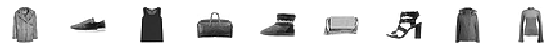

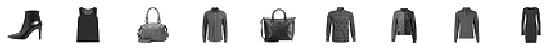

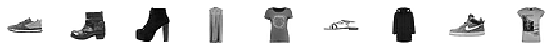

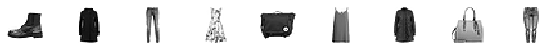

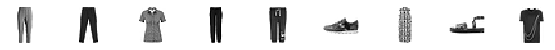

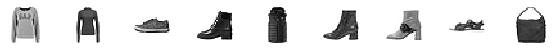

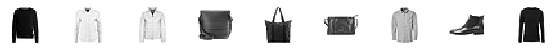

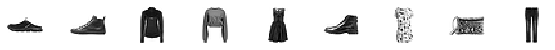

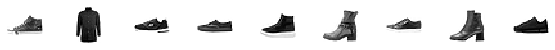

In [3]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))


for k in range(9):
    plt.figure(figsize=(10, 7))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        #plt.title(trainY[i])
        plt.axis('off')
    plt.show()

In [4]:
#Ten classes
set(trainY)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [5]:
trainX = [(image-127.5)/127.5 for image in trainX]
testX = [(image-127.5)/127.5 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# Generator Model

In [6]:
random_input = tensorflow.keras.layers.Input(shape = 100)
class_input = tensorflow.keras.layers.Input(shape = 10)

x1 = tensorflow.keras.layers.Dense(128)(random_input)

#Class Input
x2 = tensorflow.keras.layers.Dense(32)(class_input)

x = tensorflow.keras.layers.Concatenate()([x1, x2])

x = tensorflow.keras.layers.Dense(5*5*64)(x)
x = tensorflow.keras.layers.Activation('swish')(x)

x = tensorflow.keras.layers.Reshape((5, 5, 64))(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5,5))(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.BatchNormalization()(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.BatchNormalization()(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.BatchNormalization()(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(8,8))(x)
generated_image = tensorflow.keras.layers.Activation('tanh')(x)

generator_network = tensorflow.keras.models.Model(inputs=[random_input, class_input], outputs=generated_image)
generator_network.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          12928       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           352         input_2[0][0]                    
_______________________________________________________________________________________

# Discriminator

In [7]:
image_input = tensorflow.keras.layers.Input(shape=(28, 28, 1))

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3))(image_input)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.BatchNormalization()(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=2)(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.BatchNormalization()(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(5,5))(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.BatchNormalization()(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.BatchNormalization()(x)

x = tensorflow.keras.layers.Flatten()(x)

x = tensorflow.keras.layers.Dense(128)(x)
x = tensorflow.keras.layers.BatchNormalization()(x)

features = tensorflow.keras.layers.Activation('swish')(x)

d_out1 = tensorflow.keras.layers.Dense(1)(features)
real_vs_fake_output = tensorflow.keras.layers.Activation('sigmoid')(d_out1)


d_out2 = tensorflow.keras.layers.Dense(10)(features)
class_output = tensorflow.keras.layers.Activation('softmax')(d_out2)

discriminator_network = tensorflow.keras.models.Model(inputs=image_input, outputs=[real_vs_fake_output, class_output])

print (discriminator_network.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 26, 26, 128)  1280        input_3[0][0]                    
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 26, 26, 128)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 26, 26, 128)  512         activation_5[0][0]               
_______________________________________________________________________________________

In [8]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_network.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=adam_optimizer,\
                              metrics=['accuracy'])


# GAN

In [9]:
discriminator_network.trainable=False

g_output = generator_network([random_input, class_input])

d_output = discriminator_network(g_output)

ac_gan_model = tensorflow.keras.models.Model(inputs = [random_input, class_input], outputs=d_output)
ac_gan_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 28, 28, 1)    2091425     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
functional_3 (Functional)       [(None, 1), (None, 1 1644171     functional_1[0][0]    

# Compiling InfoGAN

In [10]:
ac_gan_model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=adam_optimizer)

# Define Data Generators

In [11]:
indices = [i for i in range(0, len(trainX))]

def encode_class_input(value):
    x = np.zeros((10))
    x[value]=1
    return x

def decode_class_input(value):
    return np.where(value==1)[0][0]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batches = np.reshape(random_values, (batch_size, noise_size))
    class_inputs = []
    for i in range(batch_size):
        class_input = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], size=1)
        class_inputs.append(encode_class_input(class_input))
    class_inputs = np.array(class_inputs)
    return random_noise_batches, class_inputs

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batches, class_inputs= get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch([random_noise_batches, class_inputs])
    return fake_samples, class_inputs

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    real_classes = np.array([encode_class_input(x) for x in trainY[np.array(random_indices),]])
    return real_images, real_classes

def show_generator_results(generator_network):
    random_noise_batches, class_inputs= get_random_noise(10, noise_size) 
    fake_samples = generator_network.predict_on_batch([random_noise_batches, class_inputs])

    for k in range(5):
        plt.figure(figsize=(10, 7))
        for j in range(5):
            i = j
            plt.subplot(550 + 1 + j)
            plt.imshow(fake_samples[i,:,:,-1], cmap='gray_r')
            plt.axis('off')
            plt.title(decode_class_input(class_inputs[i]))
        plt.show()
    return

# Training GAN

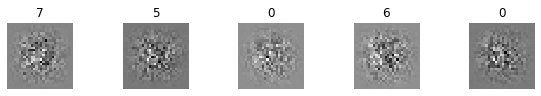

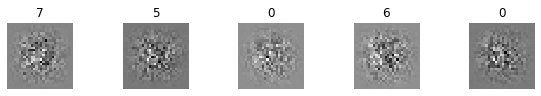

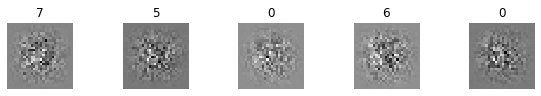

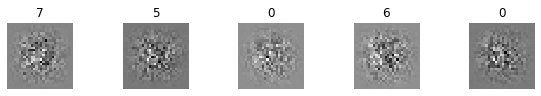

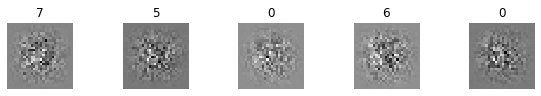

Epoch:0, Step:0, D-Loss1:3.270, D-Loss2:2.434, D-Acc1:83.571, D-Acc2:54.000, G-Loss1:2.996, G-Loss2:0.694
Epoch:0, Step:50, D-Loss1:1.255, D-Loss2:1.215, D-Acc1:4.024, D-Acc2:100.000, G-Loss1:3.040, G-Loss2:0.816


KeyboardInterrupt: 

In [12]:
epochs = 500
batch_size = 100
steps = 500
noise_size = 100

for i in range(0, epochs):
    if (i%10 == 0):
        op = show_generator_results(generator_network)
        #print (op)
    for j in range(steps):
        fake_samples, fake_classes = get_fake_samples(generator_network, batch_size//2, noise_size)
        real_samples, real_classes = get_real_samples(batch_size=batch_size//2)

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))
        
        input_samples = np.vstack((fake_samples, real_samples))
        class_labels = np.vstack((fake_classes, real_classes))
        output_labels = np.vstack((fake_y, real_y))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d = discriminator_network.train_on_batch(input_samples, [output_labels, class_labels])
        
        noise_batches, class_inputs = get_random_noise(batch_size, noise_size)
        ac_gan_input = [noise_batches, class_inputs]
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        d_output = np.ones((batch_size))
        
        ac_gan_output = [d_output, class_inputs]
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g = ac_gan_model.train_on_batch(ac_gan_input, ac_gan_output)
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss1:%.3f, D-Loss2:%.3f, D-Acc1:%.3f, D-Acc2:%.3f, G-Loss1:%.3f, G-Loss2:%.3f"%\
                   (i,j,loss_d[0],loss_d[2],loss_d[1]*100,loss_d[3]*100,loss_g[0], loss_g[1]))
            

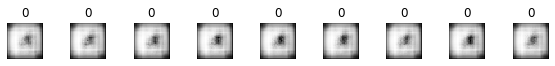

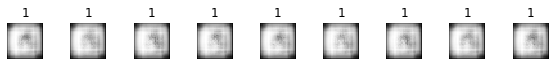

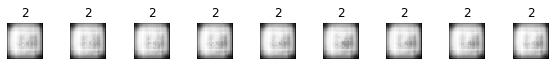

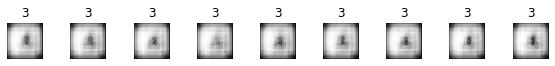

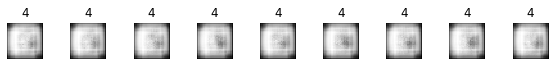

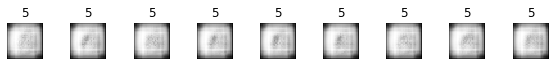

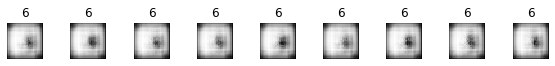

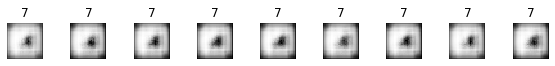

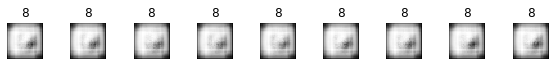

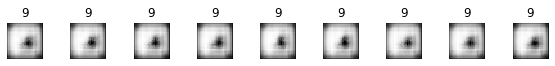

In [14]:
for k in range(10):
    random_noise_batches, _= get_random_noise(10, noise_size)
    class_inputs = []
    for p in range(10):
        class_inputs.append(encode_class_input(k))
    class_inputs = np.array(class_inputs)
    fake_samples = generator_network.predict_on_batch([random_noise_batches, class_inputs])
    plt.figure(figsize=(10, 7))
    for j in range(9):
        i = j
        plt.subplot(990 + 1 + j)
        plt.imshow(fake_samples[i,:,:,-1], cmap='gray_r')
        plt.axis('off')
        plt.title(decode_class_input(class_inputs[i]))
    plt.show()